# Testing re-clustering after napari

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def show_spots(images) :

    if isinstance(images, np.ndarray) :
        images = [images]
    if len(images) > 1 :
        fig, axes = plt.subplots(1, len(images))
    elif len(images) == 1 :
        fig = plt.figure()
        axes = [fig.gca()]

    for ax, im in zip(axes, images) :
        ax.imshow(im)
    plt.show()

## Initializing spots

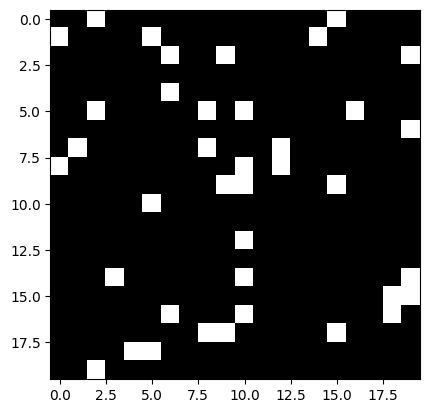

In [76]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

SEED = 1
random_generator = np.random.default_rng(seed=SEED)

SHAPE = (20,20)
SPOTS_NUM = 40
CLUSTER_RADIUS = 2
MIN_SPOT = 4

image = np.zeros(SHAPE + (3,), dtype=np.uint8)
spots = random_generator.integers([0]*len(SHAPE),SHAPE, (SPOTS_NUM,len(SHAPE)))

spot_image = image.copy()
spot_image[tuple(list(zip(*spots)))] = 255
show_spots([spot_image])

## Computing clusters

In [83]:
dbscan_model = DBSCAN(CLUSTER_RADIUS, min_samples=MIN_SPOT)
dbscan_model.fit(spots)

spots_labels = dbscan_model.labels_.reshape(len(spots),1)

spots_first_clustering = np.concatenate([spots, spots_labels], axis=1)
cluster_number = len(np.unique(spots_first_clustering[:,-1])) - 1
print("{0} clusters found.".format(cluster_number))

2 clusters found.


### Visualisation with clustered spots in red

((9, 15, 16, 9, 14, 8, 8, 15), (10, 19, 18, 9, 19, 10, 12, 18))
[[255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]
 [255   0   0]]


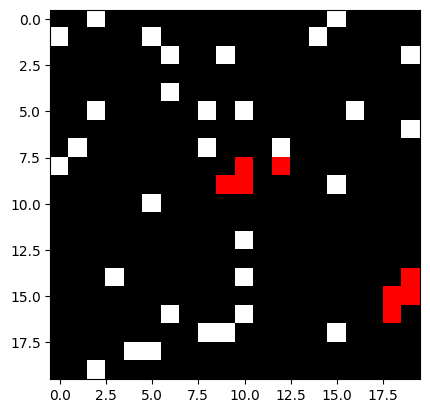

In [82]:
clustered_spots_index = tuple(list(zip(*spots_first_clustering[:,:-1][spots_first_clustering[:,-1] != -1])))

spot_image[clustered_spots_index] = [255,0,0]

print(clustered_spots_index)
print(spot_image[clustered_spots_index])
show_spots(spot_image)

## Adding a new cluster

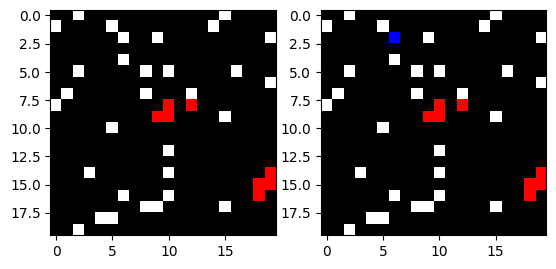

In [84]:
NEW_CLUSTER_COORDINATES = (2,6) # Shown in blue; in software this is picked by user during Napari correction.
corrected_image = spot_image.copy()
corrected_image[NEW_CLUSTER_COORDINATES] = [0,0,255]
show_spots([spot_image, corrected_image])

### Using sklearn.NearestNeighbours to find spots in radius of new cluster

[array([ 4, 14, 21])]


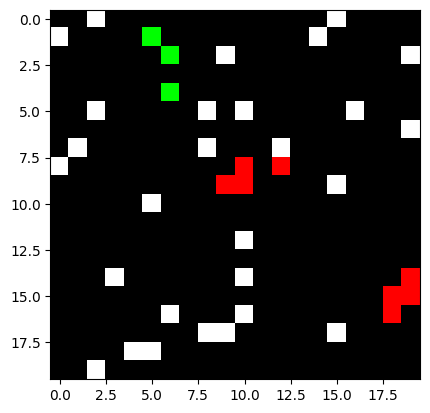

In [121]:
NearestNeighbors_model = NearestNeighbors(radius=CLUSTER_RADIUS)
NearestNeighbors_model.fit(spots)
query = NearestNeighbors_model.radius_neighbors(np.array([NEW_CLUSTER_COORDINATES], dtype=int), return_distance=False)
neighbours = spots[query[0]]
indexer = tuple(list(
    zip(*neighbours)
))
corrected_image[indexer] = [0,255,0]
show_spots(corrected_image)

## Changing weights so that 2nd round of DBSCAN add the new cluster and only that one.

In [108]:
weights = np.ones(len(spots), dtype=float) 
number_in_radius = len(neighbours)
weights[query[0]] = MIN_SPOT/number_in_radius # >1
print(weights)

[1.         1.         1.         1.         1.33333333 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.33333333 1.         1.         1.
 1.         1.         1.         1.33333333 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [114]:
second_dbscan = DBSCAN(CLUSTER_RADIUS, min_samples=MIN_SPOT)
second_dbscan.fit(spots, sample_weight= weights)
spots_labels = second_dbscan.labels_.reshape(len(spots),1)
spots_second_clustering = np.concatenate([spots, spots_labels], axis=1)


### Visualisation with clustered spots in red

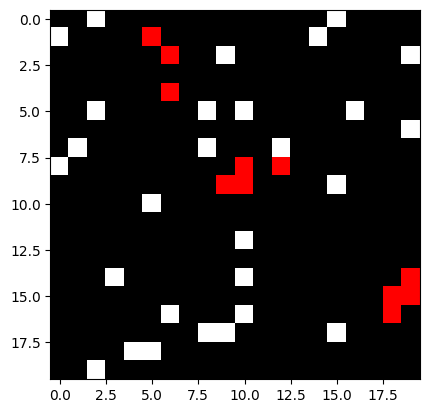

In [117]:
clustered_spots_index = tuple(list(zip(*spots_second_clustering[:,:-1][spots_second_clustering[:,-1] != -1])))
corrected_image[clustered_spots_index] = [255,0,0]
show_spots(corrected_image)

from bigfish.detection import cluster_detection